# Image Analysis of clothes and an ML predictive model

### Loading and processing the dataset from Joel Grus's Dataset

In [ ]:
import os
import cv2
import glob
from PIL import Image
import PIL
import numpy as np

pathnames = ['/users/sohit/Downloads/shirts/','/users/sohit/Downloads/jersey/',
             '/users/sohit/Downloads/males/','/users/sohit/Downloads/women/']
dataset = []

for pathname in pathnames:
    img_dir = pathname # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*JPEG')
    files = glob.glob(data_path)
    
    for i in range(500): # Extracing 500 images for each category
        
        img = Image.open(files[i])
        new = img.resize((10,10)) # Resizing the images
        dataset.append(np.array(new).flatten()) # Flattening the images to get the right format of the array
        

In [2]:
targets = [] # Creating the target variable, 0 for shirts, 1 for jerseys, 2 for male clothes and 3 for females
for i in range(4):
    for j in range(500):
        targets.append(i)

from random import shuffle, seed
data = [[dataset[i],targets[i]] for i in range(1000)]

shuffle(data) #Shuffling the data to get rid of collinearity

In [3]:
images = [image for [image,target] in data]  # Separating the data
target = [target for [image,target] in data]

In [4]:
global_pixel_means = np.mean(images) # Reorienting the images
image_data = images - global_pixel_means

# Shirts Vs. Jerseys

In [5]:
from sklearn.model_selection import train_test_split # Splitting the data into 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(image_data,target,test_size=0.2,stratify=target)

In [7]:
# An Initial Logistic regression without any additional component decomposition
# With this counterfactual, we can evaluate the improvement by PCA and LDA   

from sklearn.linear_model import LogisticRegression 

initial_model = LogisticRegression(solver='liblinear', multi_class='ovr')
initial_model.fit(X_train, y_train)

print("Train Score", initial_model.score(X_train, y_train))
print("Test score", initial_model.score(X_test, y_test))

Train Score 0.83875
Test score 0.53


In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(initial_model, image_data, target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.56 0.54 0.53 0.48 0.5  0.51 0.63 0.58 0.6  0.61]


### LDA for dimensionality reduction and accuracy boost

In [9]:
# Training the LDA model over the entire dataset

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(image_data, target)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [10]:
# Getting reduced representations of the training and test dataset

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [11]:
# Fitting the same model to the reduced representation to observe the improvement

lda_model = LogisticRegression(solver='liblinear', multi_class='ovr')
lda_model.fit(X_train_lda, y_train)

print("LDA Train Score", lda_model.score(X_train_lda, y_train))
print("LDA Test score", lda_model.score(X_test_lda, y_test))

LDA Train Score 0.77375
LDA Test score 0.79


In [12]:
# Detailed classification report of the classification in the LDA combined with the Logistic Regression

from sklearn.metrics import classification_report

pred = lda_model.predict(X_test_lda)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       100
           1       0.76      0.84      0.80       100

   micro avg       0.79      0.79      0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



In [13]:
scores = cross_val_score(lda_model, lda.transform(image_data), target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.81 0.82 0.75 0.73 0.74 0.71 0.81 0.76 0.8  0.82]


### Testing PCA for dimensionality reduction and accuracy boost Vs. LDA

In [14]:
from sklearn.decomposition import PCA

# I fit an initial PCA to the data and then autotune the number of components that explain more than 1% of the data. 
# This is done to capture components with a good explanation of the data yet not overfit the data

initial_pca = PCA(n_components=None, random_state=0)
X = initial_pca.fit(image_data)

number_of_components = len(np.where(initial_pca.explained_variance_ratio_>.01)[0])

pca = PCA(n_components=number_of_components, random_state=0)

In [15]:
print(number_of_components)

12


In [16]:
# Fitting the PCA analysis to the entire dataset and then creating the reduced representations

pca.fit(image_data)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [17]:
print('Total Explained variance ratio: %s'
      % str(round(sum(pca.explained_variance_ratio_)*100,2)), '%')

Total Explained variance ratio: 69.65 %


In [19]:
# Running the Logistic regression on the reduced representation to observe the improvement in accuracy

pca_model = LogisticRegression(solver='liblinear', multi_class='ovr')
pca_model.fit(X_train_pca, y_train)

print("PCA Train Score", pca_model.score(X_train_pca, y_train))
print("PCA Test score", pca_model.score(X_test_pca, y_test))

PCA Train Score 0.6325
PCA Test score 0.57


In [20]:
from sklearn.metrics import classification_report
pred2 = pca_model.predict(X_test_pca)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       100
           1       0.57      0.57      0.57       100

   micro avg       0.57      0.57      0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200



In [21]:
scores = cross_val_score(pca_model, pca.transform(image_data), target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.72 0.59 0.63 0.6  0.49 0.58 0.57 0.61 0.6  0.67]


### Comparative Analysis of the PCA's error rate with the allowed number of components

In [23]:
train_scores = []
test_scores = []
number_of_components = range(1,100)

for num in number_of_components:
    pca = PCA(n_components= num)
    pca.fit(image_data)
    
    x_train_pca = pca.transform(X_train)
    x_test_pca = pca.transform(X_test)
    
    model = LogisticRegression(solver='liblinear', multi_class='ovr')
    model.fit(x_train_pca, y_train)
    
    train_scores.append(1-model.score(x_train_pca,y_train))
    test_scores.append(1-model.score(x_test_pca,y_test))

[]

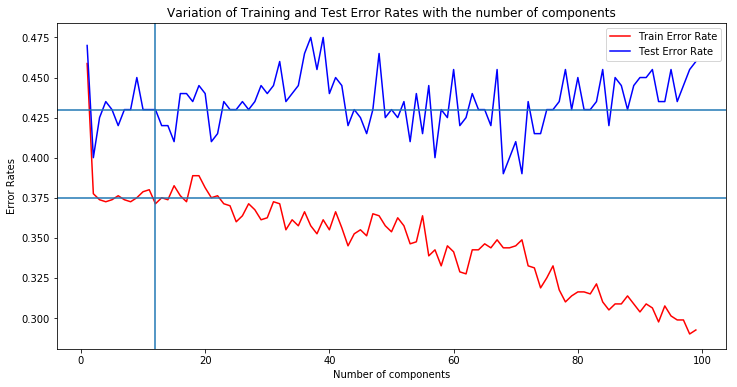

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Variation of Training and Test Error Rates with the number of components')
plt.plot(number_of_components,train_scores,color='red',label='Train Error Rate')
plt.plot(number_of_components,test_scores,color='blue',label='Test Error Rate')
plt.axvline(12)
plt.axhline(0.43)
plt.axhline(0.375)
plt.xlabel('Number of components')
plt.ylabel('Error Rates')
plt.legend()
plt.plot()

### Creating Visualizations to understand the decision boundaries built by PCA and LDA

In [30]:
# Transforimg all the shirts
shirts = np.array(image_data)[np.where(np.array(target)==0)]
shirts = lda.transform(shirts)

In [31]:
# Transforimg all the jerseys
jerseys = np.array(image_data)[np.where(np.array(target)==1)]
jerseys = lda.transform(jerseys)

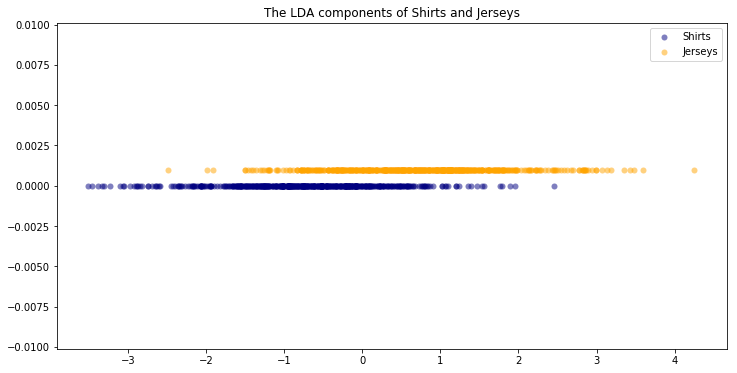

In [32]:
# Plotting the LDA components to observe the discrimination

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.title('The LDA components of Shirts and Jerseys')
plt.scatter(shirts,[0 for i in range(500)], color = 'navy',lw=0.01, alpha=.5, label= 'Shirts')
plt.scatter(jerseys,[0.001 for i in range(500)], color = 'orange', lw=0.01, alpha=.5, label= 'Jerseys')
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [33]:
shirts = np.array(image_data)[np.where(np.array(target)==0)]
shirts_pca = pca.transform(shirts)
jerseys = np.array(image_data)[np.where(np.array(target)==1)]
jerseys_pca = pca.transform(jerseys)

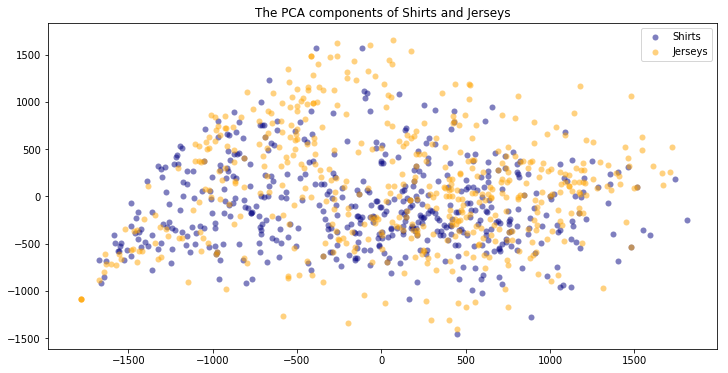

In [34]:
# Plotting the first 2 PCA components to observe the discrimination

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('The PCA components of Shirts and Jerseys')
plt.scatter(shirts_pca[:,0],shirts_pca[:,1]  , color = 'navy', alpha=.5, lw=0.01, label= 'Shirts')
plt.scatter(jerseys_pca[:,0], jerseys_pca[:,1] , color = 'orange', alpha=.5, lw=0.01, label= 'Jerseys')
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

# Male Vs. Female Clothing

In [35]:
# Consolidating, shuffling and pre-processing the data for the make vs female analysis

data = [[dataset[i],targets[i]] for i in range(1000,2000)]
shuffle(data)

images = [image for [image,target] in data]  # Separating the data
target = [target for [image,target] in data]

global_pixel_means = np.mean(images) # Reorienting the images
image_data = images - global_pixel_means

X_train, X_test, y_train, y_test = train_test_split(image_data, target, test_size=0.2, stratify=target)

In [36]:
# Initial regression model on the dataset as a counterfactual to observe the improvement with LDA/ PCA

from sklearn.linear_model import LogisticRegression
initial_model = LogisticRegression(solver='liblinear', multi_class='ovr')
initial_model.fit(X_train, y_train)

print("Train Score", initial_model.score(X_train, y_train))
print("Test score", initial_model.score(X_test, y_test))

Train Score 0.85
Test score 0.635


In [37]:
scores = cross_val_score(initial_model, image_data, target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.6  0.58 0.68 0.64 0.55 0.57 0.6  0.55 0.61 0.51]


### LDA

In [38]:
# Training the LDA 

lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(image_data, target)

#obtaining the reduced representation

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

# Training the logistic regression on the reduced representation

lda_model = LogisticRegression(solver='liblinear', multi_class='ovr')
lda_model.fit(X_train_lda, y_train)

# Improved Scores

print("LDA Train Score", lda_model.score(X_train_lda, y_train))
print("LDA Test score", lda_model.score(X_test_lda, y_test))

LDA Train Score 0.8025
LDA Test score 0.8


In [39]:
# Classification Report of the LDA Classification

from sklearn.metrics import classification_report

pred = lda_model.predict(X_test_lda)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           2       0.79      0.81      0.80       100
           3       0.81      0.79      0.80       100

   micro avg       0.80      0.80      0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



In [40]:
scores = cross_val_score(lda_model, lda.transform(image_data), target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.82 0.78 0.84 0.79 0.81 0.9  0.77 0.76 0.75 0.78]


### PCA

In [41]:
# Training the initial PCA over the entire dataset to obtain number of components that have a variation > 1%
# We run a final PCA with that number of components
from sklearn.decomposition import PCA
initial_pca = PCA(n_components=None, random_state=0)
X = initial_pca.fit(image_data)

number_of_components = len(np.where(initial_pca.explained_variance_ratio_>.01)[0])

pca = PCA(n_components=number_of_components, random_state=0)

pca.fit(image_data)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [42]:
print(number_of_components)

14


In [43]:
print('Explained variance ratio:', str(round(sum(pca.explained_variance_ratio_)*100,2)), '%')

Explained variance ratio: 68.63 %


In [44]:
# Training the logistic regression over the reduced representation

pca_model = LogisticRegression(solver='liblinear', multi_class='ovr')
pca_model.fit(X_train_pca, y_train)

# New Scores

print("PCA Train Score", pca_model.score(X_train_pca, y_train))
print("PCA Test score", pca_model.score(X_test_pca, y_test))

PCA Train Score 0.68375
PCA Test score 0.625


In [45]:
from sklearn.metrics import classification_report
pred2 = pca_model.predict(X_test_pca)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           2       0.65      0.55      0.59       100
           3       0.61      0.70      0.65       100

   micro avg       0.62      0.62      0.62       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0.63      0.62      0.62       200



In [46]:
scores = cross_val_score(pca_model, pca.transform(image_data), target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.69 0.63 0.68 0.65 0.65 0.69 0.61 0.59 0.59 0.69]


In [47]:
train_scores = []
test_scores = []
number_of_components = range(1,100)

for num in number_of_components:
    pca = PCA(n_components= num)
    pca.fit(image_data)
    
    x_train_pca = pca.transform(X_train)
    x_test_pca = pca.transform(X_test)
    
    model = LogisticRegression(solver='liblinear', multi_class='ovr')
    model.fit(x_train_pca, y_train)
    
    train_scores.append(1-model.score(x_train_pca,y_train))
    test_scores.append(1-model.score(x_test_pca,y_test))

[]

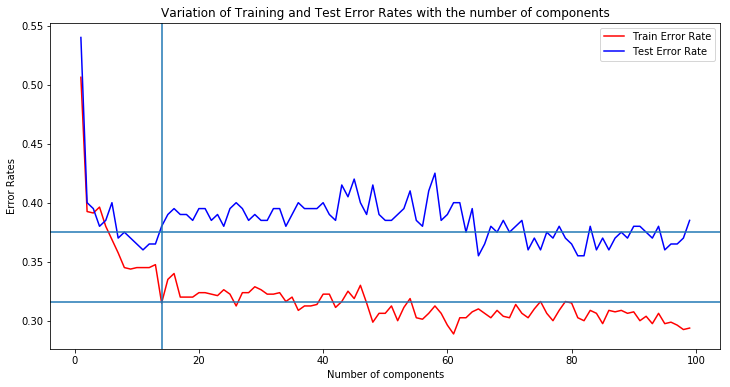

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Variation of Training and Test Error Rates with the number of components')
plt.plot(number_of_components,train_scores,color='red',label='Train Error Rate')
plt.plot(number_of_components,test_scores,color='blue',label='Test Error Rate')
plt.axvline(14)
plt.axhline(1-0.68375)
plt.axhline(0.375)
plt.xlabel('Number of components')
plt.ylabel('Error Rates')
plt.legend()
plt.plot()

### Visuals

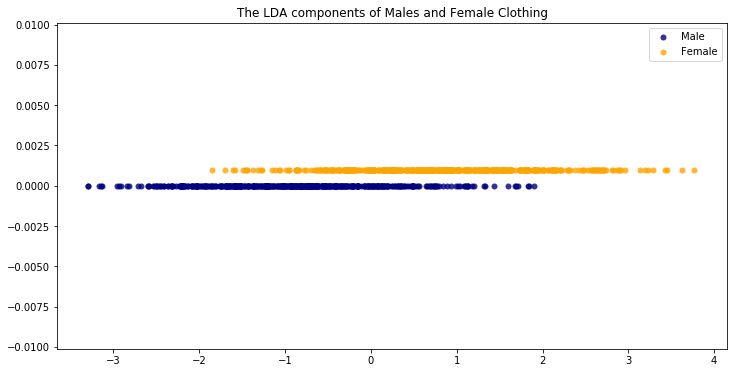

In [49]:
# Plotting the reduced representations for the LDA

male = np.array(image_data)[np.where(np.array(target)==2)]
female = np.array(image_data)[np.where(np.array(target)==3)]  

male_lda = lda.transform(male)
female_lda = lda.transform(female)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.title('The LDA components of Males and Female Clothing')
plt.scatter(male_lda,[0 for i in range(500)], color = 'navy',lw=0.01, alpha=.8, label= 'Male')
plt.scatter(female_lda,[0.001 for i in range(500)], color = 'orange', lw=0.01, alpha=.8, label= 'Female')
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

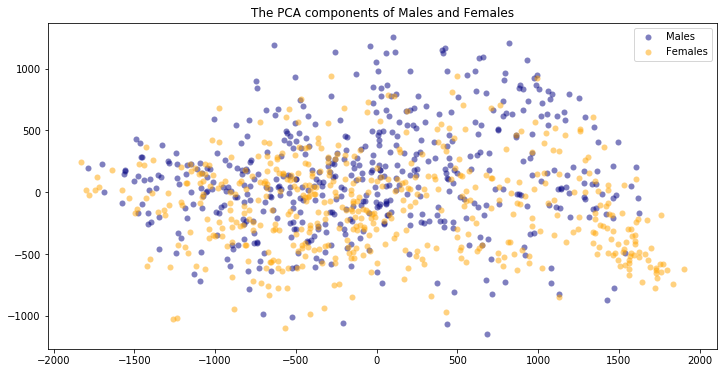

In [50]:
# Plotting the reduced representations for the PCA

male_pca = pca.transform(male)
female_pca = pca.transform(female)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('The PCA components of Males and Females')
plt.scatter(male_pca[:,0],male_pca[:,1]  , color = 'navy', alpha=.5, lw=0.01, label= 'Males')
plt.scatter(female_pca[:,0], female_pca[:,1] , color = 'orange', alpha=.5, lw=0.01, label= 'Females')
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()